<a href="https://colab.research.google.com/github/quantority/master-s-degree-projects/blob/main/Hometasks/Base%20/ML_AI24_HT7_Kruglov_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


# **Базовое решение и пример формирования файла под submission**


In [ ]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import optuna
from catboost import cv, Pool
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)

In [ ]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('/home/jupyter/datasphere/project/test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')

In [ ]:
df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [ ]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 433))

### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

In [ ]:
# ваш EDA здесь
del train_transaction, train_identity

In [ ]:
del test_transaction, test_identity

In [ ]:
def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if pd.api.types.is_integer_dtype(df[col]):
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

In [ ]:
df_train, df_train_NAlist = reduce_mem_usage(df_train)

100%|██████████| 432/432 [01:31<00:00,  4.74it/s]


In [ ]:
df_test, df_test_NAlist = reduce_mem_usage(df_test)

100%|██████████| 433/433 [00:33<00:00, 12.98it/s]


id - drop

device_info - оставляем, потому что отстутсвие информации об утсройстве может быть важным признаком

R_emaildomain - возможно тоже

device_type - тоже

m - drop

card4 - card6 - можно попробовать восстановить так как это признаки карты, то возможно что это особые категории карт без каких то конкретных признаков

In [ ]:
df_train.dtypes

isFraud             uint8
TransactionAmt    float32
ProductCD          object
card1              uint16
card2             float32
                   ...   
id_36              object
id_37              object
id_38              object
DeviceType         object
DeviceInfo         object
Length: 432, dtype: object

Приведём категориальные признаки к соответствующему типу

In [ ]:
cat_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain',
            'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [ ]:
df_train[cat_cols] = df_train[cat_cols].astype(object)

Посмотрим на пропуски

In [ ]:
nan_cols = df_train.isna().sum().sort_values(ascending=False).to_frame().reset_index()

In [ ]:
nan_cols.loc[nan_cols[0] > 0]

,index,0
0,id_27,413605
1,id_23,413605
2,id_33,359740
3,id_30,355463
4,id_34,355391
5,DeviceInfo,325600
6,id_16,317969
7,R_emaildomain,313739
8,id_31,309598
9,DeviceType,309435


Есть очень много признаков с пропущенными значениями, избавимся от тех, в которых количество пропусков слишком большое

In [ ]:
id_for_drop  = nan_cols.loc[(nan_cols['index'].str.contains('id'))&(nan_cols[0] > 0)]['index'].values
m_for_drop = nan_cols.loc[(nan_cols['index'].str.contains('M'))&(nan_cols[0] > 0)]['index'].values

In [ ]:
df_train.drop(id_for_drop, axis=1, inplace=True)

In [ ]:
df_train.drop(m_for_drop, axis=1, inplace=True)

In [ ]:
df_train.drop(['DeviceInfo', 'DeviceType'], axis=1, inplace=True)

Оставим признаки с незначительным количеством пропусков, а также признаки характеризующие адреса эл. почты, мотивируя это тем, что пользователи могут не указывать электронную почту и заполним их

In [ ]:
df_train.fillna({'R_emaildomain': 'none_category', 'P_emaildomain': 'none_category', 'card4': 'none_category', 'card6': 'none_category'}, inplace=True)

Посмотрим на дубликаты

In [ ]:
df_train.duplicated().sum()

1173

Есть большое количество дубликатов, но избавляться от них не стоит, так как это могут быть дробные операции

В датасете много признаков, посмотрим есть ли среди них константные признаки и если есть, то избавимся от них так как важной информации они не несут

In [ ]:
constant_features = [col for col in df_train.columns if df_train[col].nunique() == 1]

constant_features

['V107']

In [ ]:
df_train.drop('V107', axis=1, inplace=True)

Посмотрим сводные статистики по числовым признакам

In [ ]:
df_train.select_dtypes(include='number').describe()

,isFraud,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.00000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000

Есть признаки с низкой дисперсией а значит, что они могут быть незначительными

Посмотрим на сбалансированность классов

In [ ]:
df_train['isFraud'].value_counts()

Теперь категориальные признаки

In [ ]:
df_train.describe(include='object')

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain
count,417559,417559,417559.0,417559.0,417559,417559.0,417559,417559.0,417559.0,417559,417559
unique,5,12275,501.0,106.0,5,111.0,5,319.0,68.0,60,61
top,W,7919,321.0,150.0,visa,226.0,debit,99.0,87.0,gmail.com,none_category
freq,301297,10407,33988.0,366862.0,272753,209561.0,306554,47973.0,365944.0,160974,313739


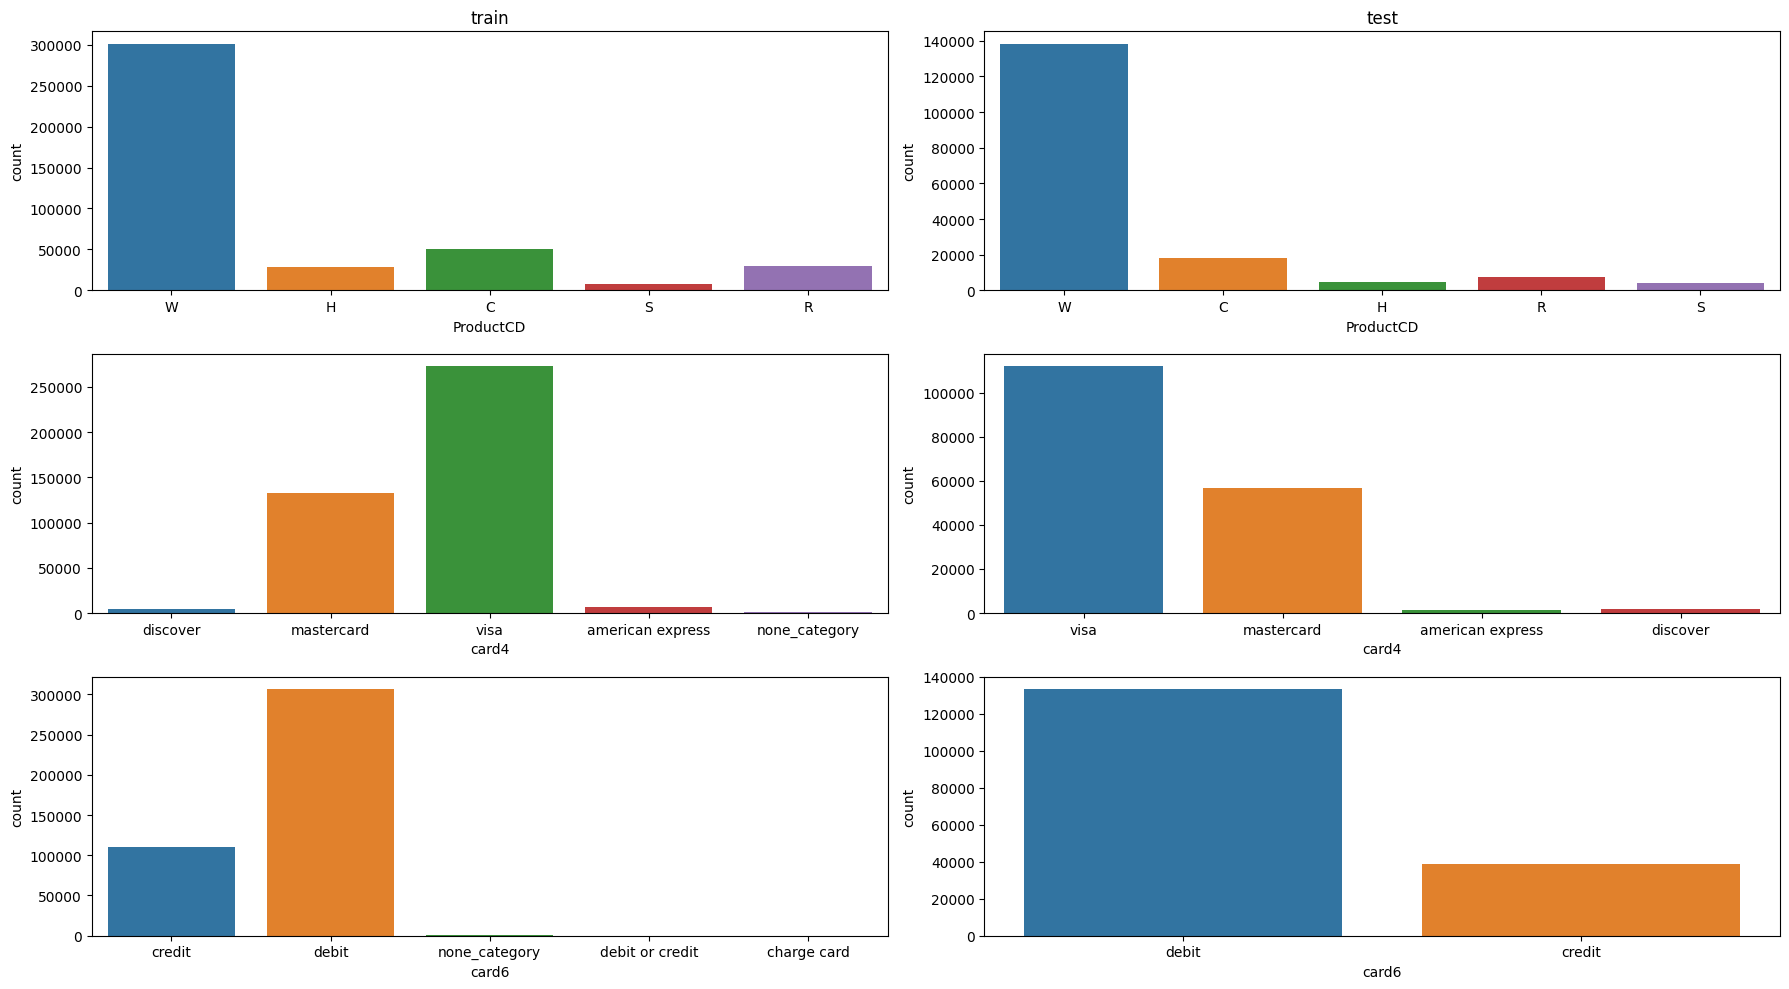

In [ ]:
cat_fts = ['ProductCD', 'card4', 'card6']
fig, ax = plt.subplots(nrows=len(cat_fts), ncols=2, figsize=(18, 10))
ax[0, 0].set_title('train')
ax[0, 1].set_title('test')
for i in range(len(cat_fts)):
    col = cat_fts[i]
    sns.countplot(x=col, ax=ax[i, 0], data=df_train)
    sns.countplot(x=col, ax=ax[i, 1], data=df_test)
plt.tight_layout()
plt.show()

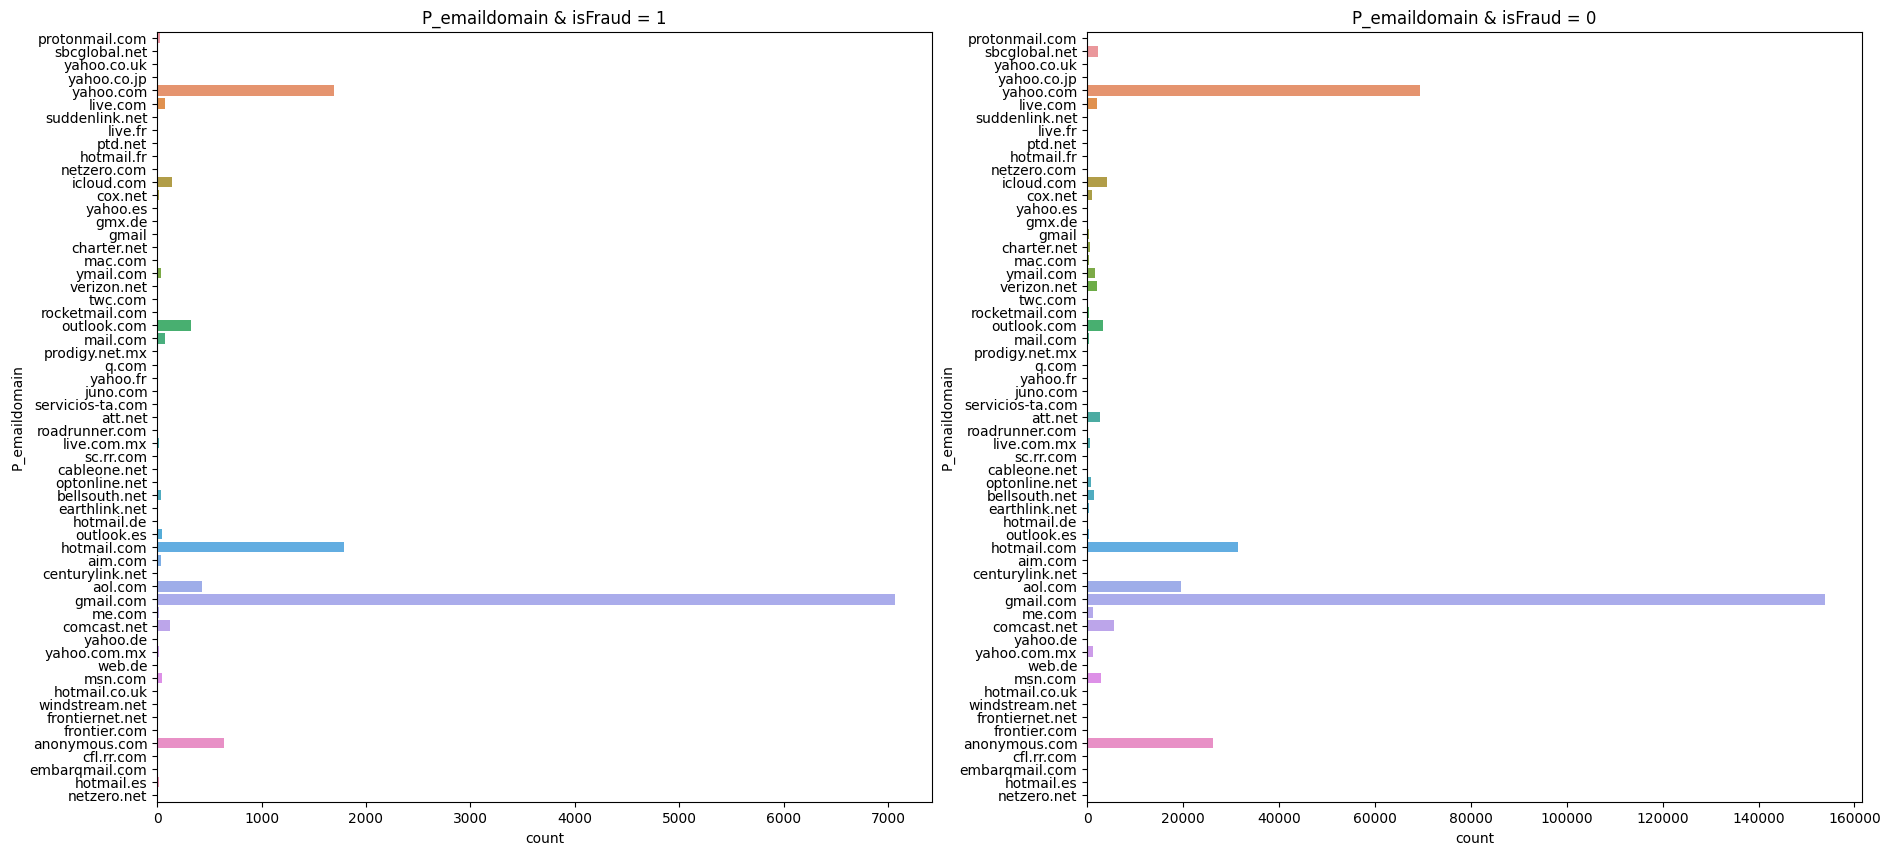

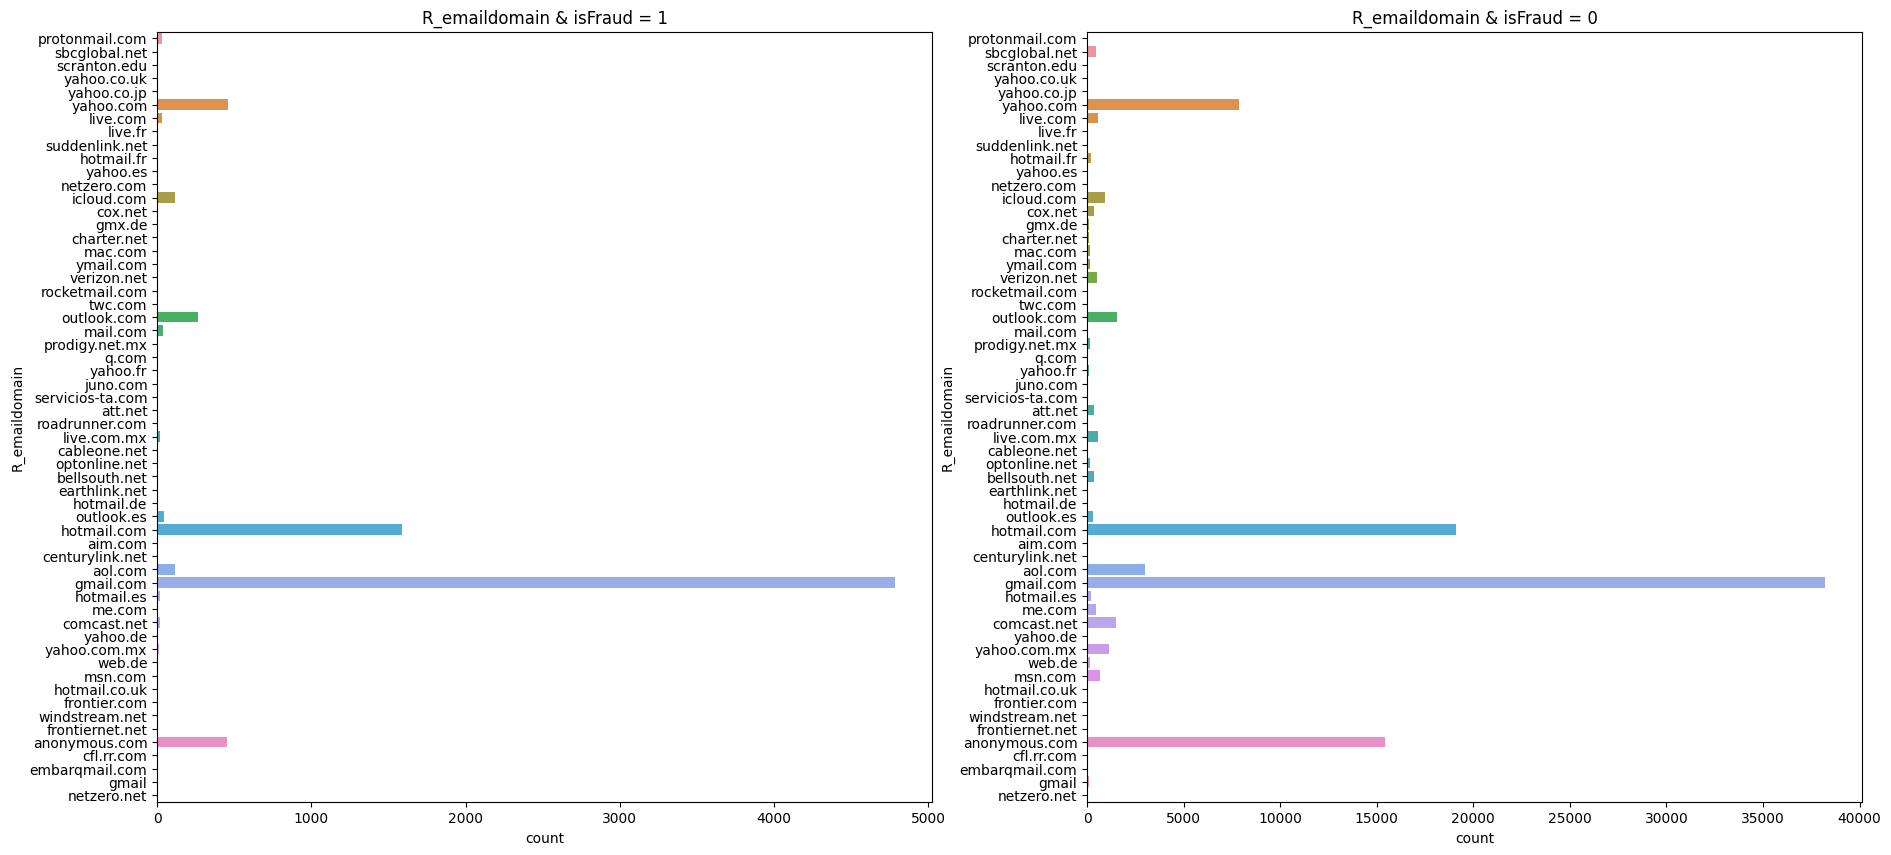

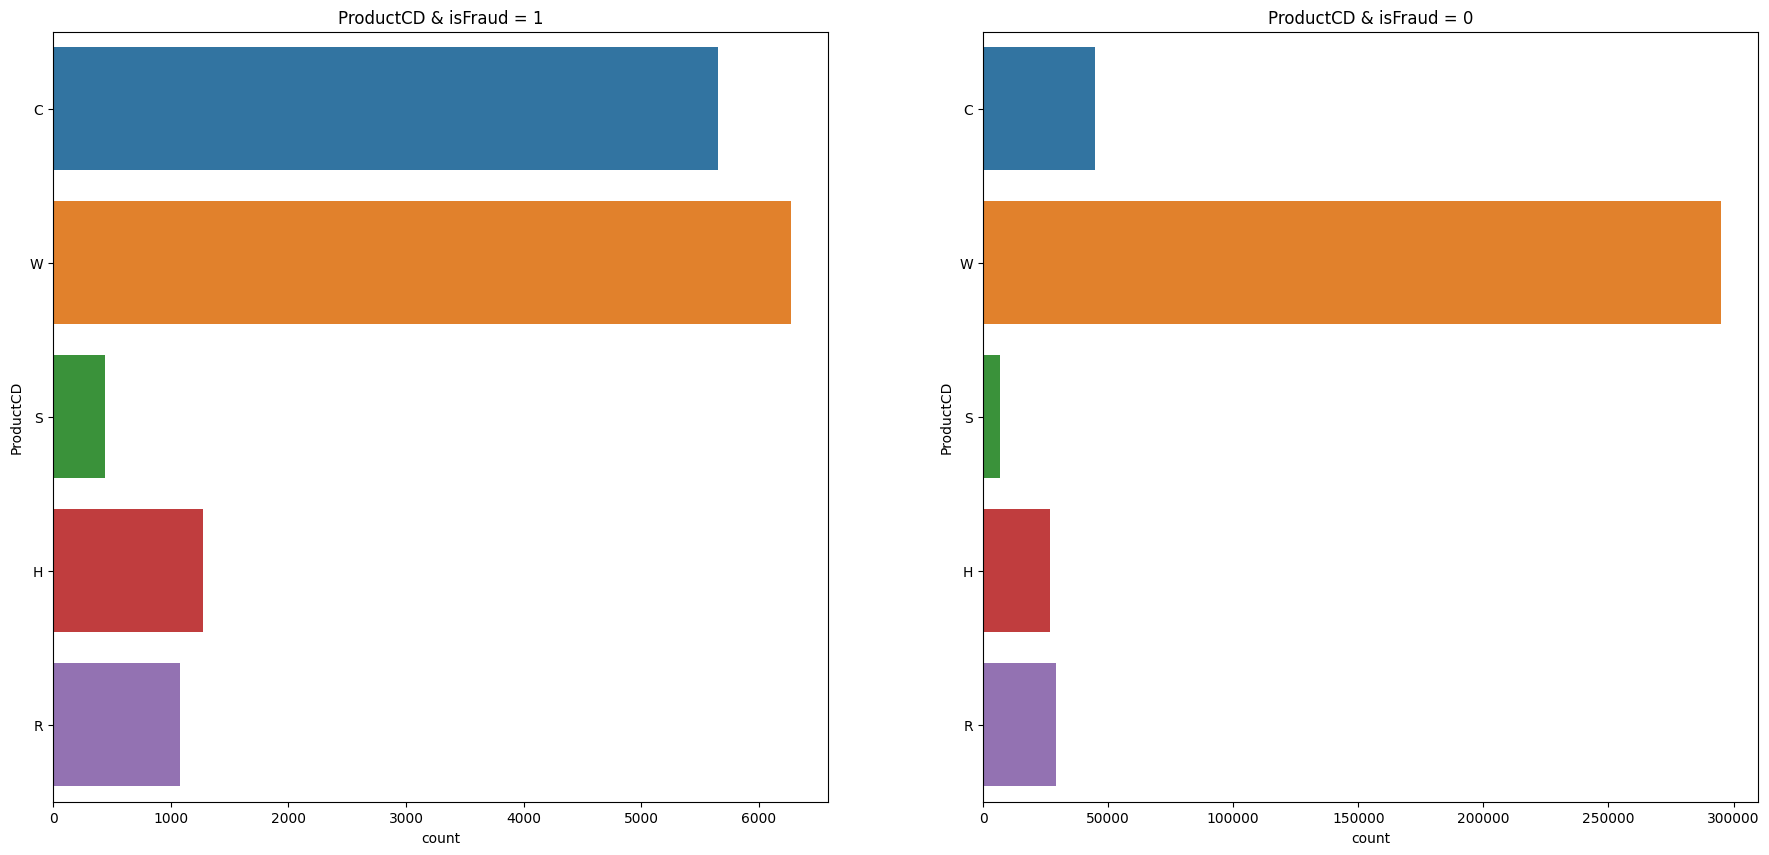

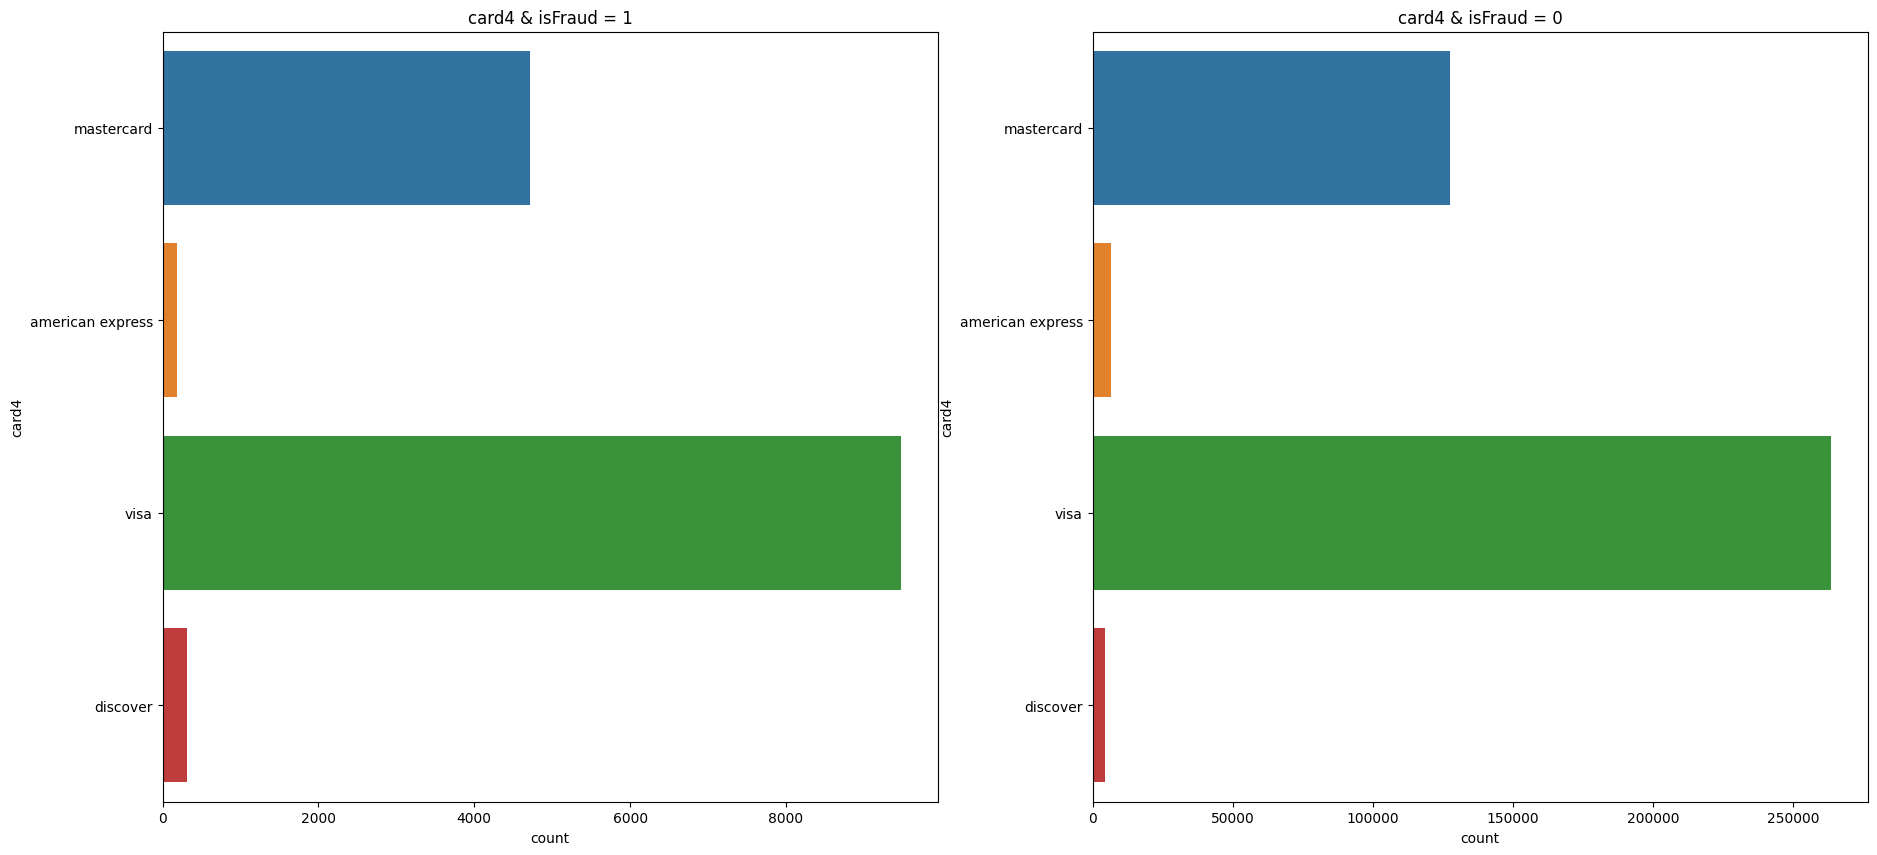

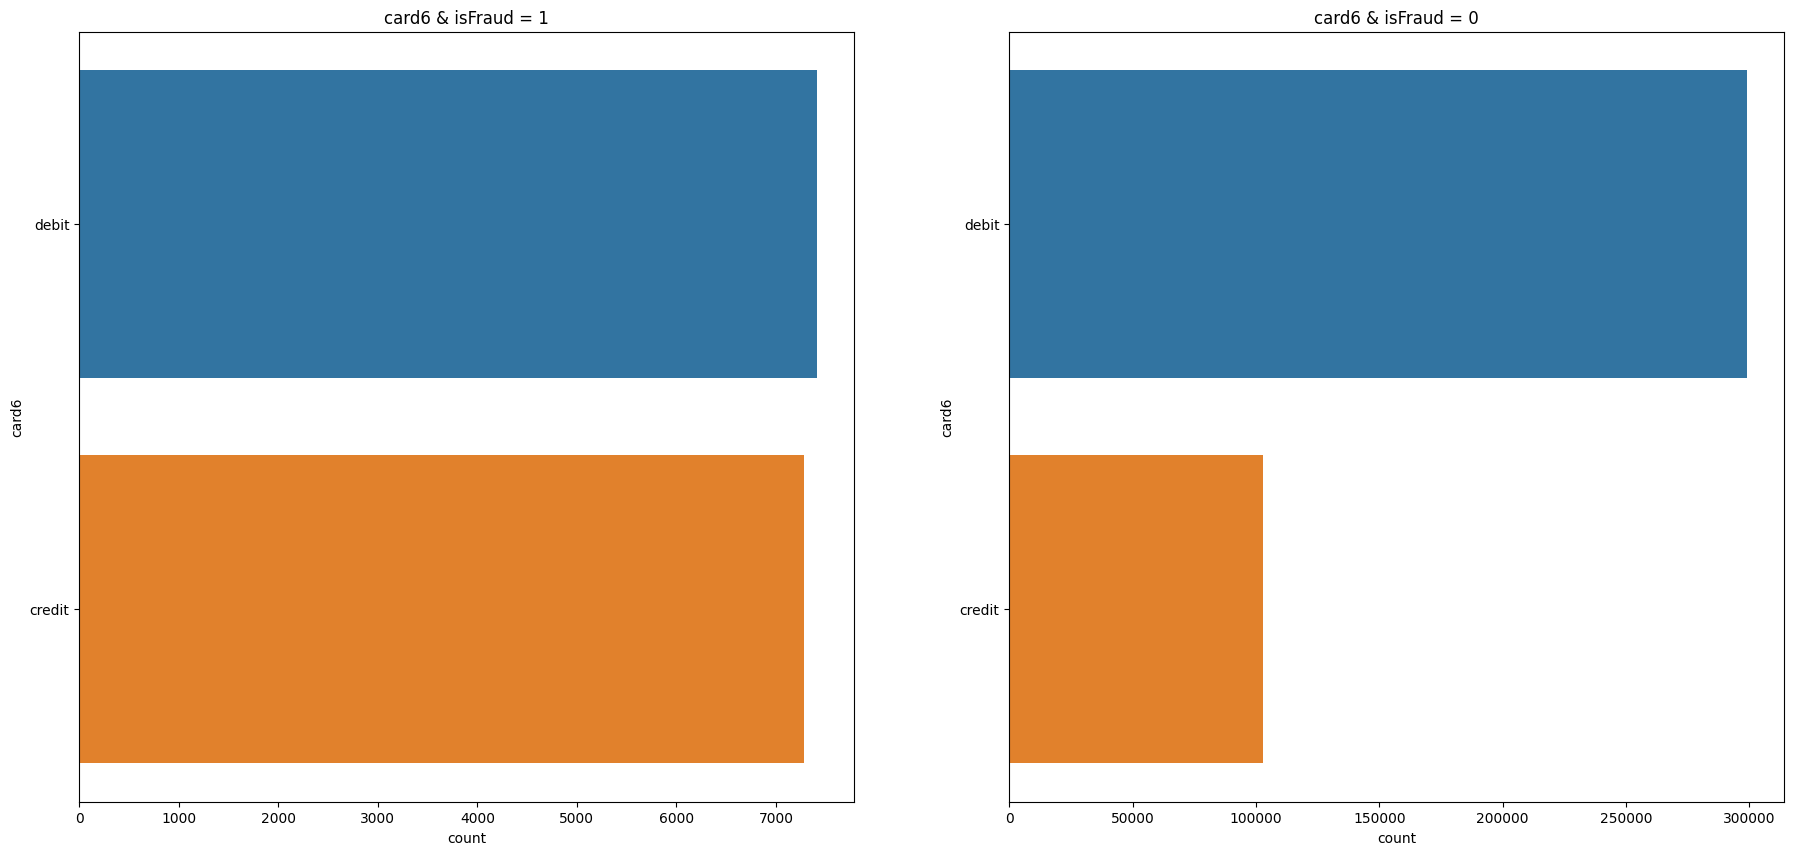

In [ ]:
cols_target = ['P_emaildomain', 'R_emaildomain', 'ProductCD', 'card4', 'card6']
for col in cols_target:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    unique_values = [x for x in list(set(df_train[col].values).intersection(set(df_test[col].values))) if str(x) != 'nan']
    sns.countplot(y=col, ax=ax[0], data=df_train.loc[df_train['isFraud'] == 1], order=unique_values)
    ax[0].set_title(col + ' & isFraud = 1')
    sns.countplot(y=col, ax=ax[1], data=df_train.loc[df_train['isFraud'] == 0], order=unique_values)
    ax[1].set_title(col + ' & isFraud = 0')
    plt.show()

По итогу EDA можно сделать вывод, что в датасете много признаков, часть из них могут быть бесполезными, поэтому на этапе обучения моделей стоит попробовать снизить размерность, некоторые категориальные признаки имеют большое количество категорий, поэтому нужно будет применять разные методы кодирования.

# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

In [ ]:
X_train = df_train.drop('isFraud', axis=1)
y_train = df_train['isFraud']

Попробуем применить методы ансамблирования.

Сделаем стекинг, в качестве базовых моделей возьмём LGBMClassifier и XGBClassifier, а в качестве мета модели LogisticRegression


План такой:

- Разобьем тренировочную выборку на тренировочную и валидационную

- Обучим базовые модели с параметрами по умолчанию и проверим метрики на кросс-валидации

- Подберём гиперпараметры

- Откалибруем модели

- Сделаем предсказания на валидационной и тестовой выборки

- Обучим мета модель на предсказаниях базовых на валидации

- Сделаем предсказание мета модели на предсказаниях базовых моделей по тестовой выборке

In [ ]:
cat_fts = X_train.select_dtypes(include='object').columns

In [ ]:
X_train[cat_fts] = X_train[cat_fts].astype(str)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=42)

Начнём с lgbm

Признаки с небольшим количеством категорий закодируем с помощью OHE, для остальных применим ordinal encoder, также попробуем избавиться от некоторых количественных переменных с помощью порога дисперсии

In [ ]:
numerical_features = X_train.select_dtypes(include='number').columns
ohe_columns = ['ProductCD', 'card4', 'card6']
label_encoder_columns = ['P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']


num_transformer_lgbm = Pipeline(steps=[
    ('variance_threshold', VarianceThreshold(threshold=0.1))
])

label_encoder_transformer_lgbm = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

ohe_transformer_lgbm = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False))
])

preprocessor_lgbm = ColumnTransformer(
    transformers=[
        ('ohe', ohe_transformer_lgbm, ohe_columns),
        ('label_encoder', label_encoder_transformer_lgbm, label_encoder_columns),
        ('variance_threshold', num_transformer_lgbm, numerical_features)
    ])

lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_lgbm),
    ('classifier', LGBMClassifier(random_state=42))
])

Посмотрим на метрику на кросс валидации

In [ ]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


cv_scores = cross_val_score(
    lgbm_pipeline,
    X_train,
    y_train,
    cv=stratified_cv,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"roc_auc: {cv_scores.mean()}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

roc_auc: 0.9580929326473777


Подберём гиперпараметры

In [ ]:
def objective(trial):
    param = {
        "verbosity": -1,
        "random_state": 42,
        "learning_rate": trial.suggest_categorical("learning_rate", [0.005, 0.01, 0.05, 0.1, 0.2]),
        "num_leaves": trial.suggest_categorical("num_leaves", [100, 300, 500]),
        "max_depth": trial.suggest_categorical("max_depth", [5, 10, 20, 30, 40, 50]),
        "min_child_samples": trial.suggest_categorical("min_child_samples", [10, 20, 30, 40, 50]),
        "subsample": trial.suggest_categorical("subsample", [0.2, 1]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.5, 0.7, 1]),
    }

    lgbm_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_lgbm),
        ('classifier', LGBMClassifier(**param))
    ])

    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = cross_val_score(
        lgbm_pipeline,
        X_train,
        y_train,
        cv=stratified_cv,
        scoring='roc_auc',
        n_jobs=-1
    )

    score = cv_scores.mean()

    return score  # Оптимизируем AUC

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 an

Немного удалось улучшить метрику

In [ ]:
lgbm_best_params = study.best_params

In [ ]:
lgbm_best_params

{'learning_rate': 0.1,
 'num_leaves': 500,
 'max_depth': 40,
 'min_child_samples': 30,
 'subsample': 1,
 'colsample_bytree': 1}

Обучим модель с подобранными гиперпараметрами и откалибруем её

In [ ]:
lgbm_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_lgbm),
        ('classifier', LGBMClassifier(learning_rate=0.1,
                                      num_leaves=500,
                                      max_depth=40,
                                      min_child_samples=30,
                                      subsample=1,
                                      colsample_bytree=1))
    ])
lgbm_pipeline.fit(X_train, y_train)

lgbm_prediction = lgbm_pipeline.predict_proba(X_val)[:,1]

lgbm_score = roc_auc_score(y_val, lgbm_prediction)

print('ROC-AUC:', lgbm_score)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ROC-AUC: 0.9638312451024394


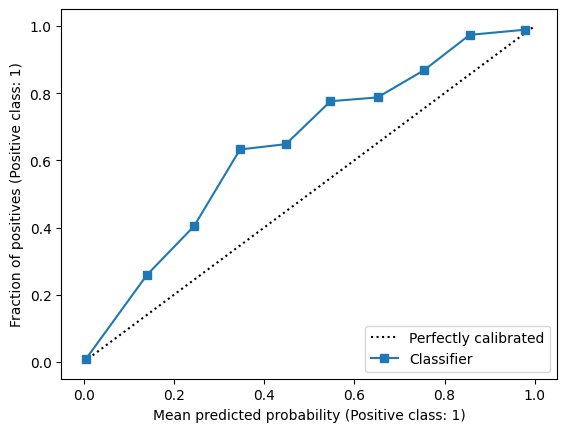

0.05430709185723668


In [ ]:
disp = CalibrationDisplay.from_predictions(y_val, lgbm_prediction, n_bins=10)
plt.show()

lgbm_log_loss = log_loss(y_val, lgbm_prediction)

print(lgbm_log_loss)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

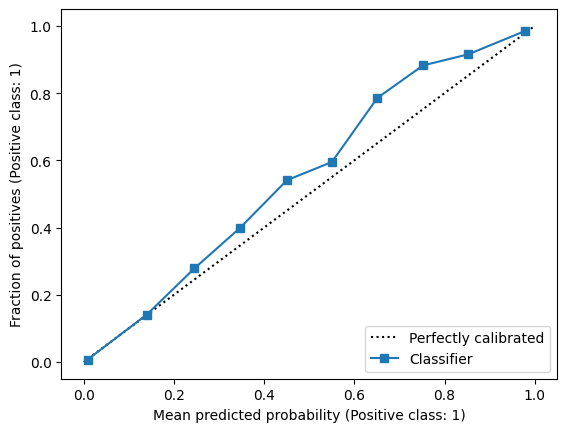

0.05086795651664293


In [ ]:
lgbm_calibrated = CalibratedClassifierCV(lgbm_pipeline, method='isotonic', cv=stratified_cv)

lgbm_calibrated.fit(X_train, y_train)

lgbm_prediction_calibrated = lgbm_calibrated.predict_proba(X_val)[:,1]

disp = CalibrationDisplay.from_predictions(y_val, lgbm_prediction_calibrated, n_bins=10)
plt.show()

lgbm_log_loss_calibrated = log_loss(y_val, lgbm_prediction_calibrated)

print(lgbm_log_loss_calibrated)

Калибровка заметно улучшила результат

Переходим к catboost, так как алгоритм умеет работать с категориальными признаками, то лишняя кодировка не потребуется

In [ ]:
numerical_features = X_train.select_dtypes(include='number').columns
cat_fts = X_train.select_dtypes(include='object').columns.to_list()


num_transformer_catboost = Pipeline(steps=[
    ('variance_threshold', VarianceThreshold(threshold=0.1))
])

preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('variance_threshold', num_transformer_catboost, numerical_features)
    ])

nums_pipe = Pipeline(steps=[('preprocessor', preprocessor_catboost)])

nums_pipe.fit(X_train)

fts_trans_names = nums_pipe.named_steps['preprocessor'].get_feature_names_out()

X_nums_transformed = nums_pipe.transform(X_train)

X_nums_df = pd.DataFrame(X_nums_transformed, columns=fts_trans_names)

X_train_catboost = X_nums_df.join(X_train[cat_fts])

X_train_catboost[cat_fts] = X_train_catboost[cat_fts].astype(str)

pool_train = Pool(X_train_catboost, y_train, cat_features=cat_fts)

params = {
    'loss_function': 'Logloss',
    'iterations': 200,
    'random_state': 42,
    'verbose': False,
    'eval_metric':'AUC',
    'cat_features':cat_fts
}


cv_data = cv(
    pool=pool_train,
    params=params,
    fold_count=5,
    stratified=True,
    shuffle=True,
    partition_random_seed=42
)

print(cv_data[['test-AUC-mean', 'test-Logloss-std']])

Training on fold [0/5]

bestTest = 0.876098583
bestIteration = 199

Training on fold [1/5]

bestTest = 0.880764467
bestIteration = 199

Training on fold [2/5]

bestTest = 0.8750624364
bestIteration = 199

Training on fold [3/5]

bestTest = 0.8717886945
bestIteration = 199

Training on fold [4/5]

bestTest = 0.8744923905
bestIteration = 199

     test-AUC-mean  test-Logloss-std
0         0.655250          0.000159
1         0.732179          0.000314
2         0.739280          0.000594
3         0.756443          0.000704
4         0.763982          0.000689
..             ...               ...
195       0.875347          0.001181
196       0.875395          0.001177
197       0.875460          0.001165
198       0.875517          0.001168
199       0.875641          0.001168

[200 rows x 2 columns]


In [ ]:
cv_data['test-AUC-mean'].max()

0.8756413142844137

Попробуем улучшить метрики с помощью подбора гиперпараметров

In [ ]:
def objective_catboost(trial):
    param = {
        "iterations": trial.suggest_categorical("iterations", [100, 200, 300, 500]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.05, 0.1, 0.3]),
        "depth": trial.suggest_categorical("depth", [5, 10, 20, 30, 40, 50]),
        "bagging_temperature": trial.suggest_categorical("bagging_temperature", [0.5, 0.7, 1]),
        "verbose": False,
        "random_state": 42,
    }

    cv_data = cv(
        pool=pool_train,
        params=params,
        fold_count=3,
        stratified=True,
        shuffle=True,
        partition_random_seed=42
    )


    score = cv_data['test-AUC-mean'].max()

    return score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_catboost = optuna.create_study(direction="maximize")
study_catboost.optimize(objective_catboost, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:   3%|▎         | 1/30 [02:05<1:00:46, 125.76s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:   7%|▋         | 2/30 [04:11<58:44, 125.87s/it]  


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  10%|█         | 3/30 [06:17<56:40, 125.93s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]

bestTest = 0.8689867596
bestIteration = 199



Best trial: 0. Best value: 0.874796:  13%|█▎        | 4/30 [08:23<54:32, 125.87s/it]

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  17%|█▋        | 5/30 [10:29<52:24, 125.79s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  20%|██        | 6/30 [12:35<50:20, 125.85s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  23%|██▎       | 7/30 [14:40<48:14, 125.86s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]

bestTest = 0.8689867596
bestIteration = 199



Best trial: 0. Best value: 0.874796:  27%|██▋       | 8/30 [16:46<46:07, 125.81s/it]

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  30%|███       | 9/30 [18:52<44:00, 125.73s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]

bestTest = 0.8689867596
bestIteration = 199



Best trial: 0. Best value: 0.874796:  33%|███▎      | 10/30 [20:57<41:53, 125.70s/it]

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  37%|███▋      | 11/30 [23:03<39:47, 125.66s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  40%|████      | 12/30 [25:09<37:41, 125.65s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  43%|████▎     | 13/30 [27:14<35:36, 125.70s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]

bestTest = 0.8689867596
bestIteration = 199



Best trial: 0. Best value: 0.874796:  47%|████▋     | 14/30 [29:20<33:32, 125.75s/it]

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  50%|█████     | 15/30 [31:26<31:25, 125.72s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  53%|█████▎    | 16/30 [33:31<29:17, 125.56s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]

bestTest = 0.8689867596
bestIteration = 199



Best trial: 0. Best value: 0.874796:  57%|█████▋    | 17/30 [35:37<27:12, 125.57s/it]

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  60%|██████    | 18/30 [37:42<25:06, 125.50s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  60%|██████    | 18/30 [39:47<25:06, 125.50s/it]


bestTest = 0.8689867596
bestIteration = 199



Best trial: 0. Best value: 0.874796:  63%|██████▎   | 19/30 [39:47<22:58, 125.36s/it]

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  67%|██████▋   | 20/30 [41:52<20:53, 125.33s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  70%|███████   | 21/30 [43:58<18:47, 125.32s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]

bestTest = 0.8689867596
bestIteration = 199



Best trial: 0. Best value: 0.874796:  73%|███████▎  | 22/30 [46:03<16:41, 125.20s/it]

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]

bestTest = 0.8689867596
bestIteration = 199



Best trial: 0. Best value: 0.874796:  77%|███████▋  | 23/30 [48:08<14:36, 125.20s/it]

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  80%|████████  | 24/30 [50:13<12:31, 125.31s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  83%|████████▎ | 25/30 [52:19<10:27, 125.46s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]

bestTest = 0.8689867596
bestIteration = 199



Best trial: 0. Best value: 0.874796:  87%|████████▋ | 26/30 [54:24<08:21, 125.40s/it]

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  90%|█████████ | 27/30 [56:30<06:16, 125.36s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  93%|█████████▎| 28/30 [58:35<04:10, 125.28s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796:  97%|█████████▋| 29/30 [1:00:40<02:05, 125.23s/it]


bestTest = 0.8689867596
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8786361365
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8767653351
bestIteration = 199

Training on fold [2/3]


Best trial: 0. Best value: 0.874796: 100%|██████████| 30/30 [1:02:46<00:00, 125.53s/it]


bestTest = 0.8689867596
bestIteration = 199



In [ ]:
cat_boost_best_params = study_catboost.best_params

In [ ]:
study_catboost.best_value

0.8747960770684866

In [ ]:
cat_boost_best_params

{'iterations': 300,
 'learning_rate': 0.3,
 'depth': 40,
 'bagging_temperature': 0.7}

В этом случае подбор гиперпараметров не дал лучшего результата

Обучим модель, сделаем предсказания на валидационной выборке и откалибруем вероятности

In [ ]:
X_nums_transformed_val = nums_pipe.transform(X_val)

X_nums_df_val = pd.DataFrame(X_nums_transformed_val, columns=fts_trans_names)

X_val_catboost = X_nums_df_val.join(X_val[cat_fts])

X_val_catboost[cat_fts] = X_val_catboost[cat_fts].astype(str)

catboost = CatBoostClassifier(
    loss_function='Logloss',
    iterations=200,
    random_state=42,
    verbose=False,
    cat_features=cat_fts
)

catboost.fit(X_train_catboost, y_train)

catboost_prediction = catboost.predict_proba(X_val_catboost)[:,1]

catboost_score = roc_auc_score(y_val, catboost_prediction)

print('ROC-AUC:', catboost_score)

ROC-AUC: 0.9115784062609913


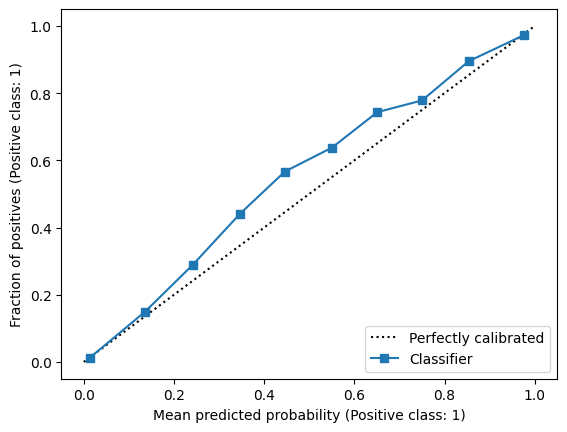

0.07779243264837722


In [ ]:
disp = CalibrationDisplay.from_predictions(y_val, catboost_prediction, n_bins=10)
plt.show()

catboost_log_loss = log_loss(y_val, catboost_prediction)

print(catboost_log_loss)

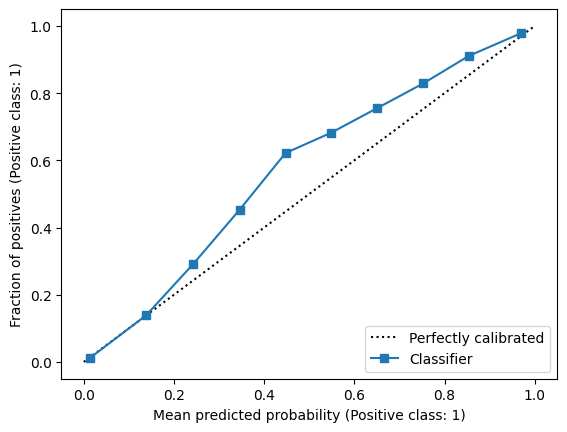

0.0766331685570594


In [ ]:
catboost_calibrated = CalibratedClassifierCV(catboost, method='isotonic', cv=stratified_cv)

catboost_calibrated.fit(X_train_catboost, y_train)

catboost_prediction_calibrated = catboost_calibrated.predict_proba(X_val_catboost)[:,1]

disp = CalibrationDisplay.from_predictions(y_val, catboost_prediction_calibrated, n_bins=10)
plt.show()

catboost_log_loss = log_loss(y_val, catboost_prediction_calibrated)

print(catboost_log_loss)

Теперь подготовим тестовую выборку, нужно оставить те же признаки, что и в данных для базовых моделей и предобработать их

Далее получим предсказания базовых моделей на тестовых данных, сформируем два признаковых пространства: одно из предсказаний на валидационной выборке, второе из предсказаний на тестовой выборке

Обучим мета алгоритм и сделаем предсказания

In [ ]:
test_forecast = df_test.drop(list(set(df_test.columns) - set(X_train)), axis=1).fillna({'R_emaildomain': 'none_category', 'P_emaildomain': 'none_category', 'card4': 'none_category', 'card6': 'none_category'})

In [ ]:
test_forecast[cat_fts] = test_forecast[cat_fts].astype(str)

Предсказания для тестовой выборки lgbm

In [ ]:
lgbm_calibrated_test_pred = lgbm_calibrated.predict_proba(test_forecast)[:,1]

In [ ]:
fts_trans_names = nums_pipe.named_steps['preprocessor'].get_feature_names_out()

X_nums_transformed_test = nums_pipe.transform(test_forecast)

X_nums_test = pd.DataFrame(X_nums_transformed_test, columns=fts_trans_names)

X_test_catboost = X_nums_test.join(test_forecast[cat_fts])

X_test_catboost[cat_fts] = X_test_catboost[cat_fts].astype(str)

Предсказания для тестовой выборки catboost

In [ ]:
catboost_calibrated_test_pred = catboost_calibrated.predict_proba(X_test_catboost)[:,1]

Формируем два признаковых пространства и обучаем мета алгоритм

In [ ]:
val_features = np.column_stack((catboost_prediction_calibrated, lgbm_prediction_calibrated))

In [ ]:
test_features = np.column_stack((catboost_calibrated_test_pred, lgbm_calibrated_test_pred))

In [ ]:
meta_model = LogisticRegression()

meta_model.fit(val_features, y_val)

In [ ]:
stacking_pred = meta_model.predict_proba(test_features)[:,1]

In [ ]:
forecast = df_test[['TransactionID']]

In [ ]:
forecast['isFraud'] = stacking_pred

/tmp/ipykernel_2619/1501685112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast['isFraud'] = stacking_pred


In [ ]:
forecast.to_csv('Submission File stacking.csv', index=False)

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
# ваши эксперименты с кластеризацией здесь

## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [ ]:
# ваш AutoML здесь

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

In [ ]:
# ваши эксперименты здесь

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

In [ ]:
# не забудьте прикрепить скриншоты лидерборда, пожалуйста